In [1]:
import os
import SimpleITK as sitk
import numpy as np
import nibabel as nib
import multiprocessing
from subprocess import call
from matplotlib import pyplot as plt

In [2]:
from skimage import filters
from scipy.ndimage import find_objects
from joblib import Parallel, delayed
from skimage.measure import regionprops
from scipy.ndimage import label as scipy_conn_comp
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure, binary_fill_holes, binary_closing

In [12]:
work_dir = '/Users/aprilyan/Documents/capstone/MSD/'
Slicer_dir = 'Users/aprilyan/Applications/Slicer-4.11.20210226-macosx-amd64.dmg'
data_path = 'Task08_HepaticVessel'
spacing = [1,1,5] # [0.8, 0.8, 1]

In [4]:
def generate_patient_list(data_path, input_tag):
    folders = sorted(os.listdir(data_path + "/"))[-3:]
    file_names = [path for path in sorted(os.listdir(data_path + input_tag + "/" + folders[0])) if path[0].isalpha()]
    return file_names

In [5]:
def generate_filepath(work_dir, data_path, input_tag, folder_tag, input_filename, subfolder):
    """
    subfolder = '/imagesTr', '/labelsTr'
    """
    input_filepath = work_dir + data_path + input_tag + subfolder +'/' + input_filename
    output_filepath = work_dir + data_path + folder_tag + subfolder + '/' + input_filename
    
    return input_filepath, output_filepath

In [6]:
data_path = "Task08_HepaticVessel" # "Task04_Hippocampus/" 
file_names = generate_patient_list(data_path, input_tag='')
print(len(file_names))

303


In [7]:
generate_filepath(work_dir, data_path, input_tag = '', subfolder='/imagesTr', input_filename=file_names[0], folder_tag='_normal')

('/Users/aprilyan/Documents/capstone/MSD/Task03_Liver/imagesTr/liver_0.nii.gz',
 '/Users/aprilyan/Documents/capstone/MSD/Task03_Liver_normal/imagesTr/liver_0.nii.gz')

## Preprocessing 3 steps: cropping, resampling, windowing

### Resampling

#### get voxel size of images

In [7]:
x, y, z = [], [], []
for i in range(len(file_names)):
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag = '', input_filename=file_names[i], folder_tag='', subfolder='/imagesTr')
    img = nib.load(input_filepath)
    sx, sy, sz = img.header.get_zooms()
    x.append(sx)
    y.append(sy)
    z.append(sz)

In [9]:
# value_arr = []
# for i in range(len(file_names)):
#     input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag='', input_filename=file_names[i], folder_tag='', subfolder='/imagesTr')
#     img = nib.load(input_filepath).get_fdata().flatten()
#     value_arr.append(img)

In [10]:
from statistics import median
print(median(x), median(y), median(z))
print(np.mean(x), np.mean(y), np.mean(z))

0.798828 0.798828 5.0
0.8048867 0.8048867 4.2402644


In [ ]:
# def resample_vol_slicer(work_dir, data_path, voxel_spacing, interp_type, slicer_dir,
#                         input_path, folder_tag, subfolder, input_filename):
#     input_filepath, output_filepath = generate_filepath(work_dir, data_path, folder_tag, input_filename, subfolder)
#     module_name = 'ResampleScalarVolume'
#     resample_scalar_volume_command = [slicer_dir,'--launch', module_name, '"' + input_path + '" "' + output_filepath + '"', 
#                                       '-i', interp_type, '-s', voxel_spacing]
#     call(' '.join(resample_scalar_volume_command), shell=True)
#     return output_filepath

In [13]:
def resample_itk(itk_image, out_spacing, is_label):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [15]:
def resampling_vol(work_dir, data_path, voxel_spacing, subfolder, input_filename, input_tag, folder_tag, is_label):
    """
    input_filepath: one for each iteration
    voxel_spacing = median (0.8, 0.8, 2.5)
    liver = median (1, 1, 1)
    """
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag, folder_tag, input_filename, subfolder)
    itk_image = sitk.ReadImage(input_filepath)
    resampled_img = resample_itk(itk_image, voxel_spacing, is_label) 
    sitk.WriteImage(resampled_img, output_filepath)
    
    return output_filepath

In [18]:
def resample_process(patient):
    resampled_img = resampling_vol(work_dir, data_path, spacing, subfolder = '/imagesTr', 
                               input_filename=patient, input_tag="", folder_tag="_resample", is_label=False)
    resampled_roi = resampling_vol(work_dir, data_path, spacing, subfolder = '/labelsTr', 
                              input_filename=patient, input_tag="", folder_tag="_resample", is_label=True)
    return print('Done')

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(resample_process)(patient) for patient in file_names[50:100])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Crop CT body part

In [19]:
lower_threshold_num = -500
num_iter_erode_dilate = 3

In [20]:
def get_largest_component(mask, se, vol):
    conn_comp, cc_num = scipy_conn_comp(mask, se)
    conn_comp_properties = regionprops(conn_comp, vol)
    largest_componenet_size = 0
    largest_componenet_index = 0
    for i in range(0, len(conn_comp_properties)):
        temp_area = conn_comp_properties[i].area
        if temp_area > largest_componenet_size:
            largest_componenet_size = temp_area
            largest_componenet_index = i
    #
    mask = conn_comp == (largest_componenet_index+1)
    return mask

In [23]:
def cropping(work_dir, data_path, input_filename, folder_tag="_crop"):
    """
    input_filepath: one for each iteration
    """
    
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag='_resample', 
                                                        folder_tag=folder_tag, input_filename=input_filename, subfolder='/imagesTr')

    vol_nib = nib.load(input_filepath)
    vol = vol_nib.get_fdata()
    affine = vol_nib.affine
    header = vol_nib.header
    #otsu threshold at lower bound
    #val = filters.threshold_otsu(vol[vol>lower_threshold_num])
    #mask = vol > val
    mask = vol > lower_threshold_num
    #get largest connected component
    se = generate_binary_structure(len(vol.shape), len(vol.shape))
    mask = get_largest_component(mask, se, vol)
    #erode mask a couple of times to get rid of table
    mask = binary_erosion(mask, se, num_iter_erode_dilate)
    #dilate mask to re-gain border
    mask = binary_dilation(mask, se, num_iter_erode_dilate)
    #fill holes in 3 different axes to account for broken surface in 3D
    mask_pre_filter = np.copy(mask)
    converged = False
    while converged == False:
        for i in range(0, mask.shape[0]):
            mask[i,:,:] = binary_fill_holes(mask[i,:,:])
        for i in range(0, mask.shape[1]):
            mask[:,i,:] = binary_fill_holes(mask[:,i,:])
        for i in range(0, mask.shape[2]):
            mask[:,:,i] = binary_fill_holes(mask[:,:,i])
        if np.all(mask_pre_filter == mask):
            converged = True
        else:
            mask_pre_filter = np.copy(mask)
    #apply closing to fix small imperfections of surface (closing affects top and bottom slices so ensure to replace those)
    mask_top = np.copy(mask[:,:,0])
    mask_bottom = np.copy(mask[:,:,-1])
    mask = binary_closing(mask)
    mask[:,:,0] = mask_top
    mask[:,:,-1] = mask_bottom
    #get largest connected component in case something accidently got added
    mask = get_largest_component(mask, se, vol)
    #save mask output
    nib_mask = nib.Nifti1Image(mask.astype(int), affine, header=header)
    nib.save(nib_mask, output_filepath)
    
    return output_filepath

In [24]:
def crop_process(patient):
    cropped_mask = cropping(work_dir, data_path, input_filename=patient)
    return print('Done')

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(crop_process)(patient) for patient in file_names)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Localize

In [13]:
def localize_vol(work_dir, data_path, subfolder, input_filename, input_tag, folder_tag):
    """
    input_filepath: one for each iteration
    voxel_spacing = median (0.8, 0.8, 2.5)
    liver = median (1, 1, 1)
    """
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag, folder_tag, input_filename, subfolder)
    #input_filepath = input_path
    nib_vol = nib.load(input_filepath)
    affine = nib_vol.affine
    header = nib_vol.header
    vol = nib_vol.get_fdata()
    if vol.shape[-1] >= 400:
        mid_up = np.max([0,int(img.shape[-1]/2)-100])
        mid_down = np.min([img.shape[-1], int((img.shape[-1]/2))+300])
        vol_crop = vol[:,:,mid_up:mid_down]
        nib_vol_local = nib.Nifti1Image(vol_crop, affine, header=header)
        nib.save(nib_vol_local, output_filepath)
    else:
        nib_vol_local = nib.Nifti1Image(vol, affine, header=header)
        nib.save(nib_vol_local, output_filepath)
    
    return output_filepath

In [34]:
file_names[0]

'liver_0.nii.gz'

In [14]:
def localize_process(patient):
#     resampled_img = localize_vol(work_dir, data_path, subfolder = '/imagesTr', 
#                                input_filename=patient, input_tag="_resample", folder_tag="_local",)
    resampled_roi = localize_vol(work_dir, data_path, subfolder = '/labelsTr', 
                              input_filename=patient, input_tag="_resample", folder_tag="_local",)
    return print('Done')

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(localize_process)(patient) for patient in file_names)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Windowing

In [25]:
file_names = generate_patient_list(data_path, '_resample')
print(len(file_names))

303


- train: range(0,201)

- val: range(201,241)

- test: range(241,281)

#### find global mean and std of body part 

In [192]:
value = 0
num = 0
for i in range(241,281): 
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag='_resample', folder_tag='_window', 
                                                    input_filename=file_names[i], subfolder='/imagesTr')
    mask_path, NA = generate_filepath(work_dir, data_path, input_tag='_crop', folder_tag='_window', 
                                                    input_filename=file_names[i], subfolder='/imagesTr')
    arr = nib.load(input_filepath).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    body = arr[mask == 1]
    
    num += len(body)
    value += np.sum(body)


In [193]:
mean = value/num
mean

-53.901892474784376

In [194]:
value_std = 0
for i in range(241,281):
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag='_resample', folder_tag='_window', 
                                                    input_filename=file_names[i], subfolder='/imagesTr')
    mask_path, NA = generate_filepath(work_dir, data_path, input_tag='_crop', folder_tag='_window', 
                                                    input_filename=file_names[i], subfolder='/imagesTr')
    arr = nib.load(input_filepath).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    body = arr[mask == 1]

    value_std += np.sum(np.square(body - mean))

In [195]:
std = np.sqrt(value_std/num)
std

246.42774069222

#### global mean and std:

- train: [-56.87, 261.21]

- val: [-55.17, 256.51]

- test: [-53.90, 246.43]

In [26]:
global_window_mean_std = np.array([[-55, 250]])  # ct_soft_tissue 
level_width = np.array([[60, 160]])  # hepatic lesion in liver, soft tissue for pancreas + cancer [60, 400]
intensity_range = np.array([[level - width/2, level + width/2] for level,width in level_width]) 
num_channels = len(intensity_range) 

In [27]:
def window_norm(patient):
    # Create windowed images and normalize images using global mean and standard deviation
    #if not np.all([os.path.exists(outputVolName) for outputVolName in outputVolNames[:-1]]):
    #load in volume
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag='_resample', folder_tag='_window', 
                                                        input_filename=patient, subfolder='/imagesTr')
    body_mask_path, NA = generate_filepath(work_dir, data_path, input_tag='_crop', folder_tag='_window', 
                                                        input_filename=patient, subfolder='/imagesTr')
    img = nib.load(input_filepath) 
    mask = nib.load(body_mask_path)
    affine = img.affine 
    header = img.header 
    #Normalize image (make zero mean and standard deviation of 1) 
    CT_vol = img.get_fdata().astype(np.float32) 
    ct_mask = mask.get_fdata().astype(np.float32) 
    
    for i in range(num_channels): 
        lower, upper = intensity_range[i,:] 
        if np.all(np.isnan([lower, upper])): 
            idx_window = np.where(ct_mask > 0) 
        else:
            idx_window = np.where((CT_vol >= lower) & (CT_vol <= upper))
        temp_ct_window = np.copy(CT_vol)
        
        #normalize inside the window and set outside the window equal to either min or max value
        temp_ct_window[idx_window] = (temp_ct_window[idx_window] - global_window_mean_std[i,0]) / global_window_mean_std[i,1]
        if not np.all(np.isnan([lower, upper])):
            temp_ct_window[np.where(CT_vol < lower)] = np.min(temp_ct_window[idx_window])
            temp_ct_window[np.where(CT_vol > upper)] = np.max(temp_ct_window[idx_window])
        #mask out volume
        temp_ct_window = temp_ct_window * ct_mask
        #save normalized volume
        CT_window_nib = nib.Nifti1Image(temp_ct_window, affine, header=header)
        nib.save(CT_window_nib, output_filepath)
        
    return print('Done')

In [29]:
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(window_norm)(patient) for patient in file_names)

# for patient in file_names:
#     window_norm(patient)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Re-ensure the labels are correct

In [17]:
label_path = 'Task07_Pancreas_resample/labelsTr/'

In [27]:
# for i in range(len(file_names)):
#     roi_file = nib.load(label_path + file_names[i])
#     roi = roi_file.get_fdata()
#     roi[(roi > 0.5) & (roi <= 1)] = 1   # roi = np.round(roi)
#     affine = roi_file.affine 
#     header = roi_file.header 
#     label = nib.Nifti1Image(roi, affine, header=header) 
#     nib.save(label, label_path + file_names[i]) 

In [31]:
np.unique(nib.load(label_path + file_names[5]).get_fdata())

array([0.        , 0.99607849, 2.00000012])

### ------------------------- test code ----------------------------

In [38]:
patient = file_names[7]
input_filepath, output_filepath = generate_filepath(work_dir, data_path, input_tag='_resample', folder_tag='_window', 
                                                        input_filename=patient, subfolder='/imagesTr')
body_mask_path, NA = generate_filepath(work_dir, data_path, input_tag='_crop', folder_tag='_window', 
                                                    input_filename=patient, subfolder='/imagesTr')
img = nib.load(input_filepath) 
mask = nib.load(body_mask_path)
affine = img.affine 
header = img.header 
#Normalize image (make zero mean and standard deviation of 1) 
CT_vol = img.get_fdata().astype(np.float32) 
ct_mask = mask.get_fdata().astype(np.float32) 

for i in range(num_channels): 
    lower, upper = intensity_range[i,:]
    if np.all(np.isnan([lower, upper])):
        idx_window = np.where(ct_mask > 0)
    else:
        idx_window = np.where((CT_vol >= lower) & (CT_vol <= upper))
    temp_ct_window = np.copy(CT_vol)

    #normalize inside the window and set outside the window equal to either min or max value
    temp_ct_window[idx_window] = (temp_ct_window[idx_window] - global_window_mean_std[i,0]) / global_window_mean_std[i,1]
    if not np.all(np.isnan([lower, upper])):
        temp_ct_window[np.where(CT_vol < lower)] = np.min(temp_ct_window[idx_window])
        temp_ct_window[np.where(CT_vol > upper)] = np.max(temp_ct_window[idx_window])
    #mask out volume
    temp_ct_window = temp_ct_window * ct_mask
    #save normalized volume
    CT_window_nib = nib.Nifti1Image(temp_ct_window, affine, header=header)

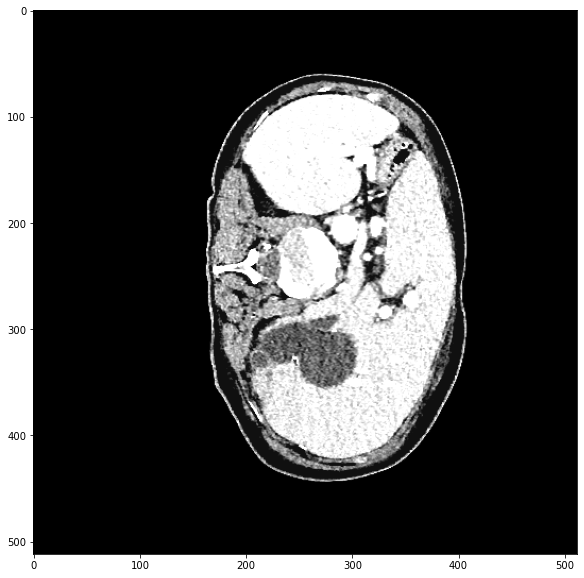

In [39]:
plt.figure(figsize = (10,10))
plt.imshow(temp_ct_window[:,:,370], cmap='gray')

In [43]:
test_path = work_dir + 'Patients_Hepatic/' + 'Train/' + 'HepaticVessel_102/' #'Task07_Pancreas/labelsTr/pancreas_001.nii.gz' 
img = nib.load(test_path + 'roi.nii.gz')
img0 = nib.load(test_path + 'image.nii.gz')
arr = img.get_fdata()
arr1 = img0.get_fdata()

In [44]:
arr.shape

(380, 380, 37)

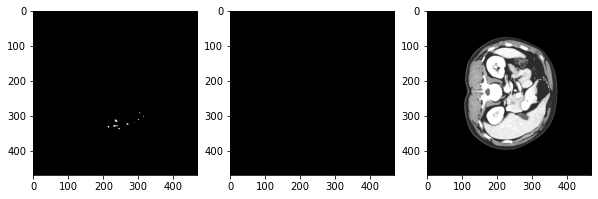

In [34]:
mask = arr[:,:,20]
image = arr1[:,:,20]
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(mask == 1,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(mask == 2,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image,cmap='gray')

In [123]:
np.where(arr == 2)

(array([150, 150, 150, ..., 186, 186, 186]),
 array([227, 227, 228, ..., 229, 229, 230]),
 array([303, 304, 303, ..., 302, 303, 303]))